<a href="https://colab.research.google.com/github/gavinadlan/Aroma-Coffe/blob/main/Metodologi_penelitian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Install libraries
!pip install scikit-learn pandas matplotlib seaborn

In [ ]:
# 2. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# 3. Upload dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

Saving Heart Disease UCI.csv to Heart Disease UCI.csv


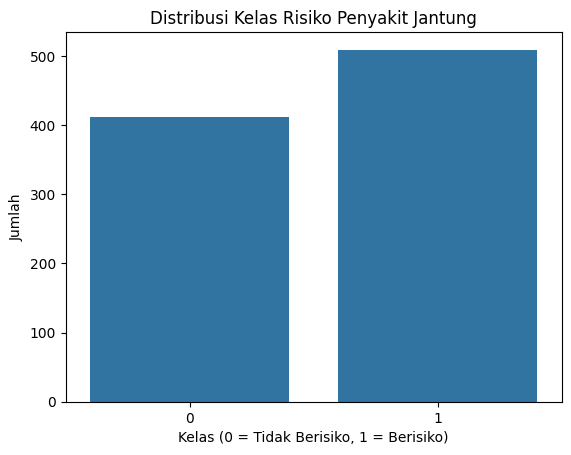

In [ ]:
# 4. Preprocessing
df.drop(columns=["id", "dataset"], inplace=True)
df["num"] = df["num"].apply(lambda x: 1 if x > 0 else 0)

# Visualisasi distribusi target
sns.countplot(x="num", data=df)
plt.title("Distribusi Kelas Risiko Penyakit Jantung")
plt.xlabel("Kelas (0 = Tidak Berisiko, 1 = Berisiko)")
plt.ylabel("Jumlah")
plt.show()

# Fitur numerik dan kategorikal
numeric_features = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

# Pipeline preprocessing
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Split data
X = df.drop("num", axis=1)
y = df["num"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [ ]:
# 5. Model dan Evaluasi
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []
probabilities = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train_prep, y_train)
    y_pred = model.predict(X_test_prep)
    y_proba = model.predict_proba(X_test_prep)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_prep)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

    probabilities[name] = y_proba
    trained_models[name] = model

# Tabel Hasil Evaluasi
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\n📊 Hasil Evaluasi Model:\n")
print(results_df)


📊 Hasil Evaluasi Model:

                 Model  Accuracy  Precision    Recall  F1-Score
1     SVM (RBF Kernel)  0.847826   0.885714  0.853211  0.869159
3        Random Forest  0.847826   0.900990  0.834862  0.866667
0  Logistic Regression  0.804348   0.847619  0.816514  0.831776
4          Naive Bayes  0.798913   0.839623  0.816514  0.827907
2        Decision Tree  0.750000   0.831579  0.724771  0.774510


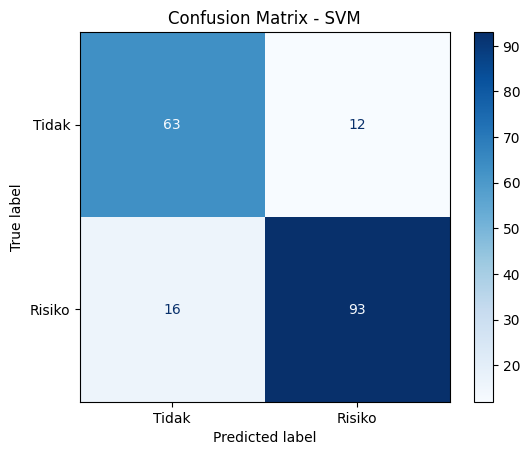

In [ ]:
# 6. Confusion Matrix - SVM
svm_model = trained_models["SVM (RBF Kernel)"]
y_pred_svm = svm_model.predict(X_test_prep)
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tidak", "Risiko"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.show()

/tmp/ipython-input-8-864879579.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df.head(10), x="Importance", y="Fitur", palette="viridis")


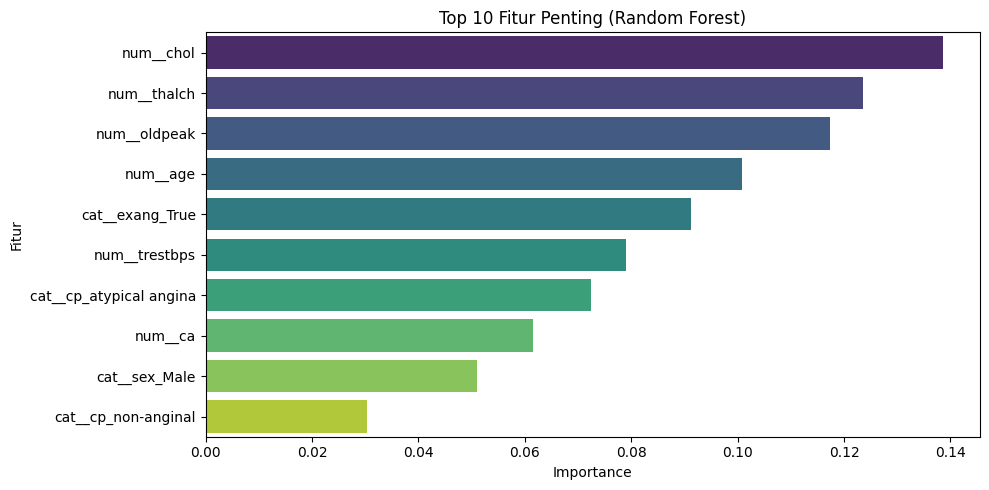

In [ ]:
# 7. Feature Importance - Random Forest
rf_model = trained_models["Random Forest"]
feature_names = preprocessor.get_feature_names_out()
importances = rf_model.feature_importances_
fi_df = pd.DataFrame({"Fitur": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=fi_df.head(10), x="Importance", y="Fitur", palette="viridis")
plt.title("Top 10 Fitur Penting (Random Forest)")
plt.tight_layout()
plt.show()

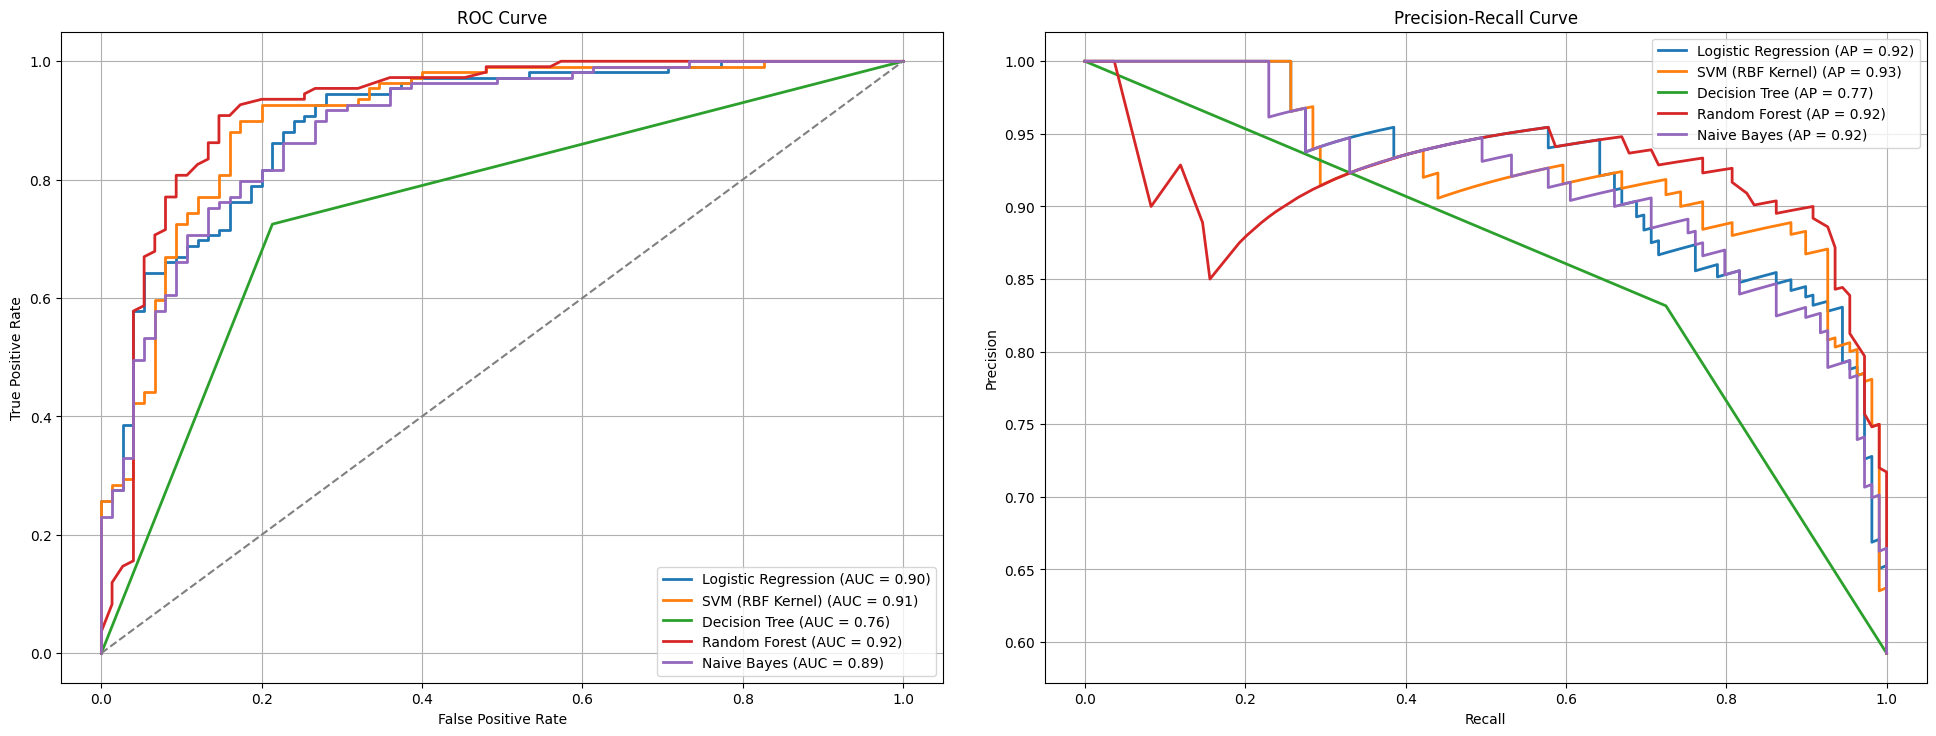

In [ ]:
# 8. ROC Curve dan Precision-Recall Curve
plt.figure(figsize=(20, 8))

# --- Subplot 1: ROC Curve ---
plt.subplot(1, 2, 1)
for name, y_prob in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

# --- Subplot 2: Precision-Recall Curve ---
plt.subplot(1, 2, 2)
for name, y_prob in probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    average_precision = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, lw=2, label=f"{name} (AP = {average_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid(True)

# Atur layout dan tampilkan
plt.tight_layout(pad=3.0)
plt.show()


/tmp/ipython-input-10-4195930223.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Kondisi Aktual")


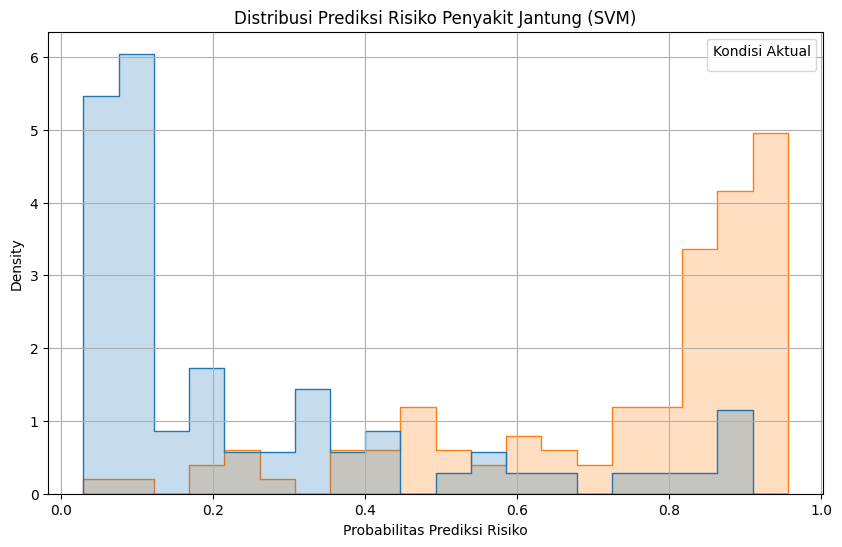

In [ ]:
# 9. Distribusi Nilai Prediksi (SVM)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=pd.DataFrame({
        "Prediksi Risiko": probabilities["SVM (RBF Kernel)"],
        "Aktual": ["Risiko" if x == 1 else "Tidak" for x in y_test]
    }),
    x="Prediksi Risiko",
    hue="Aktual",
    element="step",
    stat="density",
    common_norm=False,
    bins=20
)
plt.title("Distribusi Prediksi Risiko Penyakit Jantung (SVM)")
plt.xlabel("Probabilitas Prediksi Risiko")
plt.ylabel("Density")
plt.legend(title="Kondisi Aktual")
plt.grid(True)
plt.show()

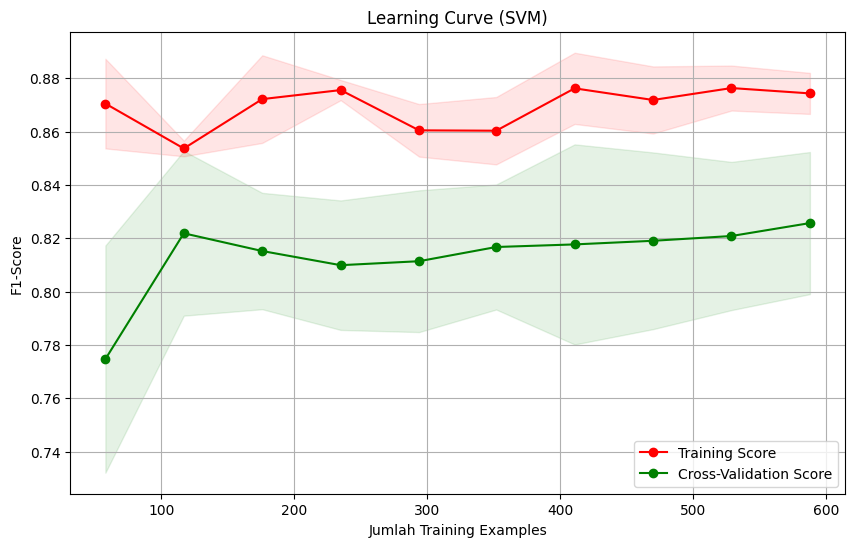

In [ ]:
# 10. Learning Curve (SVM)
train_sizes, train_scores, test_scores = learning_curve(
    svm_model,
    X_train_prep,
    y_train,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-Validation Score")
plt.title("Learning Curve (SVM)")
plt.xlabel("Jumlah Training Examples")
plt.ylabel("F1-Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()